In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

In [3]:
df = pd.read_csv('data/matrix_intDef_ec_propensity.tab', sep='\t')
df.head()

,ensID,pdbID,pos.ens,pos.pdb,aa,ASA.rel.cplx,ASA.rel.alone,nsub,sym,len,homo,cat,patch.alone.size,patch.cplx.size,patch.alone,patch.cplx
0,P76342,1xdy_5E,63,19,A,112.4,112.4,1,NPS,262,1.0,2,7,7,0.4348,0.063
1,P76342,1xdy_5E,64,20,L,19.3,19.3,1,NPS,262,1.0,1,0,0,-0.9138,0.000
2,P76342,1xdy_5E,65,21,E,98.6,98.6,1,NPS,262,1.0,2,10,10,-1.0007,-0.179
3,P76342,1xdy_5E,66,22,F,29.3,29.3,1,NPS,262,1.0,2,11,11,-2.2957,-0.093
4,P76342,1xdy_5E,67,23,S,54.6,54.6,1,NPS,262,1.0,2,8,8,-1.4256,-0.161


In [4]:
#taking only the surface aas
df2 = df.loc[df['cat']==2]
df2.head()

,ensID,pdbID,pos.ens,pos.pdb,aa,ASA.rel.cplx,ASA.rel.alone,nsub,sym,len,homo,cat,patch.alone.size,patch.cplx.size,patch.alone,patch.cplx
0,P76342,1xdy_5E,63,19,A,112.4,112.4,1,NPS,262,1.0,2,7,7,0.4348,0.063
2,P76342,1xdy_5E,65,21,E,98.6,98.6,1,NPS,262,1.0,2,10,10,-1.0007,-0.179
3,P76342,1xdy_5E,66,22,F,29.3,29.3,1,NPS,262,1.0,2,11,11,-2.2957,-0.093
4,P76342,1xdy_5E,67,23,S,54.6,54.6,1,NPS,262,1.0,2,8,8,-1.4256,-0.161
5,P76342,1xdy_5E,68,24,K,58.7,58.7,1,NPS,262,1.0,2,10,10,-0.3994,-0.158


In [5]:
#stickiness score of aa
st = pd.read_csv('data/CROWDING_EC.mat', sep='\t')
st.sort_index(inplace=True)
st = st.reset_index(drop=True)
st.head()

,ensID,pdbID,pos.ens,pos.pdb,aa,rate,ndef,ASA.rel.cplx,ASA.rel.alone,len,patch.compo.400abs,aa.prop,ab.all
0,P76342,1xdy_5E,141,97,I,0.6596,10,7.1,7.1,262,0.0,1.1109,NaN
1,P76342,1xdy_5E,142,98,Y,0.4077,10,0.1,0.1,262,0.0,0.8806,NaN
2,P76342,1xdy_5E,143,99,R,0.2909,10,21.3,21.3,262,0.0,-0.0876,NaN
3,P76342,1xdy_5E,144,100,M,0.8333,10,5.3,5.3,262,0.0,1.0124,NaN
4,P76342,1xdy_5E,140,96,R,0.2909,10,4.2,4.2,262,0.0,-0.0876,NaN


In [6]:
merged = pd.merge(df, st, on=['ensID', 'pos.ens'])


In [7]:
#merged_with_surface = df2.merge(st, on=['ensID', 'aa'])
merged_with_surface = merged.loc[merged['cat'] == 2].copy()

In [8]:
aa_prop = merged_with_surface['aa_x'].groupby([st.ensID, st.pdbID]).apply(list).reset_index()
aa_prop.head()

,ensID,pdbID,aa_x
0,O32583,1zud4,"[G, Q, D, E, K, S, L, L, E, D, T, T, E, G, K, ..."
1,P00448,1ixbB,"[D, E, P, A, K, D, K, G, K, A, A, Y, A, K, N, ..."
2,P00452,1r1r_2B,"[L, E, H, D, K, D, K, D, V, V, G, M, N, R, L, ..."
3,P00509,1x2aB,"[N, A, P, A, L, R, A, E, R, P, G, K, D, E, T, ..."
4,P00803,1b12_3C,"[E, K, I, K, K, M, D, L, L, H, K, G, T, H, E, ..."


In [9]:
aa_prop['Surface'] = aa_prop['aa_x'].apply(lambda x:''.join(x))

# Merge with ecoli

In [10]:
ecoli_w3110 = pd.read_csv('data/ecoli_eSOL_JWXXXX.csv')
ecoli_w3110[['JW', 'name', 'ECK_num']] = ecoli_w3110['Accession'].str.split(' ', expand=True)

#uniprot
a = pd.read_csv('data/ecoli_mapping.txt',sep='\t', header=None)
b = pd.DataFrame()
b[[1,2,3,4,5]] = a[0].str.split(' ', 4, expand=True)
b[['b_num', 'JW']] = b[1].str.split(';', 1, expand=True)
b = b.rename(columns={2:'Swiss-prot_entry_name', 3:'ensID', 4:'Length', 5:'Gene_name_and_synonyms'})
mapping = b[['Swiss-prot_entry_name', 'ensID','Length', 'Gene_name_and_synonyms', 'b_num', 'JW']].copy()


In [11]:
mapping.to_pickle('mapping.pkl')

In [12]:
mapped_df = pd.merge(aa_prop, mapping, on=['ensID']) #first map aa_prop
final_df = pd.merge(mapped_df, ecoli_w3110, on=['JW']) #then map with ecoli
final_df.head(1)

,ensID,pdbID,aa_x,Surface,Swiss-prot_entry_name,Length,Gene_name_and_synonyms,b_num,JW,Accession,Sequence,ECK number,Solubility(%),unknown_bases,name,ECK_num
0,P00452,1r1r_2B,"[L, E, H, D, K, D, K, D, V, V, G, M, N, R, L, ...",LEHDKDKDVVGMNRLWSGKESLDDLDNNKEQDETGGNQDRHRQGDN...,RIR1_ECOLI,761,nrdA;dnaF,b2234,JW2228,JW2228 nrdA ECK2226,MNQNLLVTKRDGSTERINLDKIHRVLDWAAEGLHNVSISQVELRSH...,ECK2226,63.0,False,nrdA,ECK2226


In [13]:
final_df.to_pickle('surface_aminoacids.pkl.gz', compression='infer')

In [21]:
df_opt = final_df[['Surface', 'Sequence', 'Solubility(%)']].copy()

# Optimisation based on surface aminoacids

In [15]:
from scipy import optimize
from functools import partial
np.random.seed(12345)


flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}


#SWI
swi = {'A': 0.8356471476582918,
 'C': 0.5208088354857734,
 'E': 0.9876987431418378,
 'D': 0.9079044671339564,
 'G': 0.7997168496420723,
 'F': 0.5849790194237692,
 'I': 0.6784124413866582,
 'H': 0.8947913996466419,
 'K': 0.9267104557513497,
 'M': 0.6296623675420369,
 'L': 0.6554221515081433,
 'N': 0.8597433107431216,
 'Q': 0.789434648348208,
 'P': 0.8235328714705341,
 'S': 0.7440908318492778,
 'R': 0.7712466317693457,
 'T': 0.8096922697856334,
 'W': 0.6374678690957594,
 'V': 0.7357837119163659,
 'Y': 0.6112801822947587}

def avaas(seq, flex):
    w = []
    for i, v in enumerate(seq):
        w.append(flex[v])
#     return np.exp(np.sum(np.log(w))/len(w)) #similar to CAI
    return w


def make_dic(arr):
    '''Make an amino acid dictionary from an array of values
    '''
    dic = {}
    ks = [k for k, v in flexibilities_smith.items()]
    for i, v in enumerate(ks):
        dic[v] = arr[i]
    return dic



def cost_func(f, df):
    #based on surface amino acids only
    #use for optimisation because p value isnt needed
    flex = make_dic(f)
    df['f'] = df['Surface'].apply(lambda x:avaas(x, flex))
    df['Average_flexibility'] = df['f'].apply(lambda x:np.mean(x))
    corr, pval = spearmanr(df['Average_flexibility'],df['Solubility(%)'])
    return -corr


def cost_func_p_val(f, df):
    #based on surface amino acids only, but returns p value as well
    flex = make_dic(f)
    df['f'] = df['Surface'].apply(lambda x:avaas(x, flex))
    df['Average_flexibility'] = df['f'].apply(lambda x:np.mean(x))
    corr, pval = spearmanr(df['Average_flexibility'],df['Solubility(%)'])
    return corr, pval


def cost_func_full(f, df):
    #based on full sequence
    flex = make_dic(f)
    df['f'] = df['Sequence'].apply(lambda x:avaas(x, flex))
    df['Average_flexibility'] = df['f'].apply(lambda x:np.mean(x))
    corr, pval = spearmanr(df['Average_flexibility'],df['Solubility(%)'])
    return corr, pval


In [16]:
#Optimise weights based on b-factors


init_state = [v for k, v in flexibilities_smith.items()]
cost_function = partial(cost_func, df=df_opt)

#Optimise cost function using init_state as starting point
optimize.minimize(cost_function, init_state, method="Nelder-Mead", \
                  options={ 'maxiter': 3000, 'maxfev': 3000,\
                           'disp': False, 'return_all': False,\
                           'xatol': 0.001, 'fatol': 0.0001, 'adaptive': True})

 final_simplex: (array([[0.81596706, 0.66853512, 0.85975908, 0.77159892, 0.84932142,
        0.59741109, 0.7375771 , 0.91208781, 0.86704017, 0.65159511,
        0.73957961, 0.8857533 , 0.74111919, 0.83450509, 0.87744017,
        0.7637244 , 0.90424   , 0.55021555, 0.53379988, 0.60266292],
       [0.81593751, 0.66837797, 0.85977324, 0.77153819, 0.84925993,
        0.59734825, 0.73768572, 0.91206963, 0.86716873, 0.65168659,
        0.73956794, 0.88570947, 0.7410773 , 0.83457062, 0.87748139,
        0.76374816, 0.90419071, 0.55018514, 0.53379239, 0.60266273],
       [0.81596174, 0.66851021, 0.85978386, 0.77151292, 0.84929394,
        0.59743091, 0.73753843, 0.91210737, 0.86694727, 0.65158688,
        0.73960915, 0.88574755, 0.74105448, 0.83445071, 0.87747495,
        0.76368178, 0.90428754, 0.55020695, 0.53389025, 0.60265988],
       [0.81596352, 0.66843072, 0.85977457, 0.7715017 , 0.84930011,
        0.59733109, 0.73755745, 0.9120338 , 0.86703314, 0.65167793,
        0.7396636 , 0.885809

In [18]:
#find correlation based on weights optimised based on surface amino acids
optimised_weights = [0.81596706, 0.66853512, 0.85975908, 0.77159892, 0.84932142,
       0.59741109, 0.7375771 , 0.91208781, 0.86704017, 0.65159511,
       0.73957961, 0.8857533 , 0.74111919, 0.83450509, 0.87744017,
       0.7637244 , 0.90424   , 0.55021555, 0.53379988, 0.60266292]

cost_func_p_val(optimised_weights, df_opt)

(0.18044464640174, 0.0007200171905495313)

In [22]:
#using SWI for full length not just surface amino acids

init_state =  [v for k, v in swi.items()]

cost_func_full(init_state, df_opt)

(0.4557913661991376, 2.966579733735365e-19)

## Conclusion
Optimisation based on surface amino acids didnt lead to any significant improvement in correlation with solubility. However, if we take full sequence into consideration and use AAS, correlation is much improved (0.45, p-val 2.97 x 10^(-19))

## Scatterplot

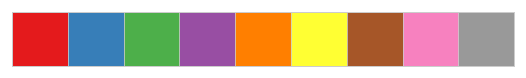

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
sns.set_palette("Set1")
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [45]:
#run surface_AA.ipynb first to get this file
scoring_surface = pd.read_pickle('surface_aminoacid_scoring.pkl.gz')

In [32]:
#scoring with optimised weights
new_dict = make_dic(optimised_weights)
df_opt['f'] = df_opt['Surface'].apply(lambda x:avaas(x, new_dict))
df_opt['Optimised score based on surface residue'] = df_opt['f'].apply(lambda x:np.mean(x))


In [41]:
#scoring with swi weights for full sequence
df_opt['ff'] = df_opt['Sequence'].apply(lambda x:avaas(x, swi))
df_opt['SWI'] = df_opt['ff'].apply(lambda x:np.mean(x))


In [94]:
spearmanr(scoring_surface['Stickiness score'], scoring_surface['Solubility(%)'])

SpearmanrResult(correlation=-0.05145269119617839, pvalue=0.3385580978337458)

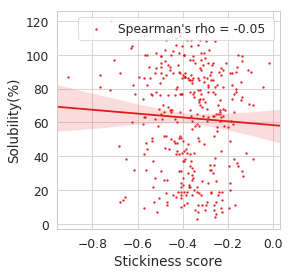

In [120]:
plt.figure(figsize=(4, 4))
ax = sns.regplot(scoring_surface['Stickiness score'], scoring_surface['Solubility(%)'], \
            marker='o', color=current_palette[0], scatter_kws={'s':2}, label="Spearman's rho = -0.05 ")
ax.legend(loc="best")
# plt.savefig('stickiness_score_and_solubility.pdf', bbox_inches = 'tight', pad_inches = 0)

In [97]:
spearmanr(df_opt['Optimised score based on surface residue'], scoring_surface['Solubility(%)'])

SpearmanrResult(correlation=0.18044464640174, pvalue=0.0007200171905495313)

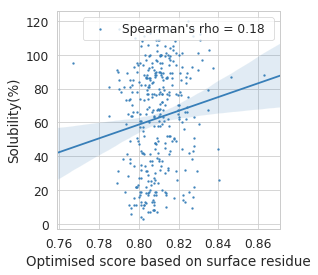

In [110]:
plt.figure(figsize=(4, 4))
ax = sns.regplot(df_opt['Optimised score based on surface residue'], scoring_surface['Solubility(%)'], \
           marker='o', color=current_palette[1],  scatter_kws={'s':2}, label="Spearman's rho = 0.18 ")
ax.legend(loc="best")
plt.savefig('optimised_score_and_solubility.pdf', bbox_inches = 'tight', pad_inches = 0)

In [98]:
spearmanr(df_opt['SWI'], scoring_surface['Solubility(%)'])

SpearmanrResult(correlation=0.4557913661991376, pvalue=2.966579733735365e-19)

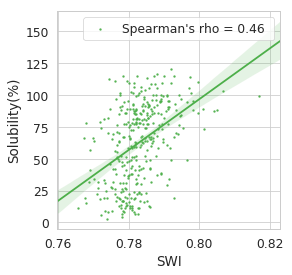

In [111]:
plt.figure(figsize=(4, 4))
ax = sns.regplot(df_opt['SWI'], scoring_surface['Solubility(%)'], \
           marker='o', color=current_palette[2], scatter_kws={'s':2}, label="Spearman's rho = 0.46 ")
ax.legend(loc="best")
plt.savefig('SWI_and_solubility.pdf', bbox_inches = 'tight', pad_inches = 0)

In [112]:
df_opt.shape

(348, 9)